In [ ]:
import torch
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [20]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

## Data

In [21]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # Normalization of ImageSet (necessary if we use model pre-trained in ImageSet, such as ResNet-34)
                         std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # Normalization of ImageSet (necessary if we use model pre-trained in ImageSet, such as ResNet-34)
                         std=[0.229, 0.224, 0.225])
])

train_data = OxfordIIITPet(
    root="../data",
    split="trainval",
    transform=train_transform,
    download=True
)
test_data = OxfordIIITPet(
    root="../data",
    split="test",
    transform=test_transform,
    download=True
)
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f'Size of the images: {train_data[0][0].shape}')

Training samples: 3680
Test samples: 3669
Size of the images: torch.Size([3, 224, 224])


In [22]:
class_names = train_data.classes
label_to_breed = {i:name for i, name in enumerate(class_names)}  # Map between the labels and the names of the pet breeds

CAT_BREEDS = {
    "Abyssinian", "Bengal", "Birman", "Bombay", "British_Shorthair", 
    "Egyptian_Mau", "Maine_Coon", "Persian", "Ragdoll", "Russian_Blue", 
    "Siamese", "Sphynx"
}

label_to_species = {i: ('cat' if name in CAT_BREEDS else 'dog')   # Map between the labels and the species of the animal (cat or dog)
                    for i, name in enumerate(class_names)}

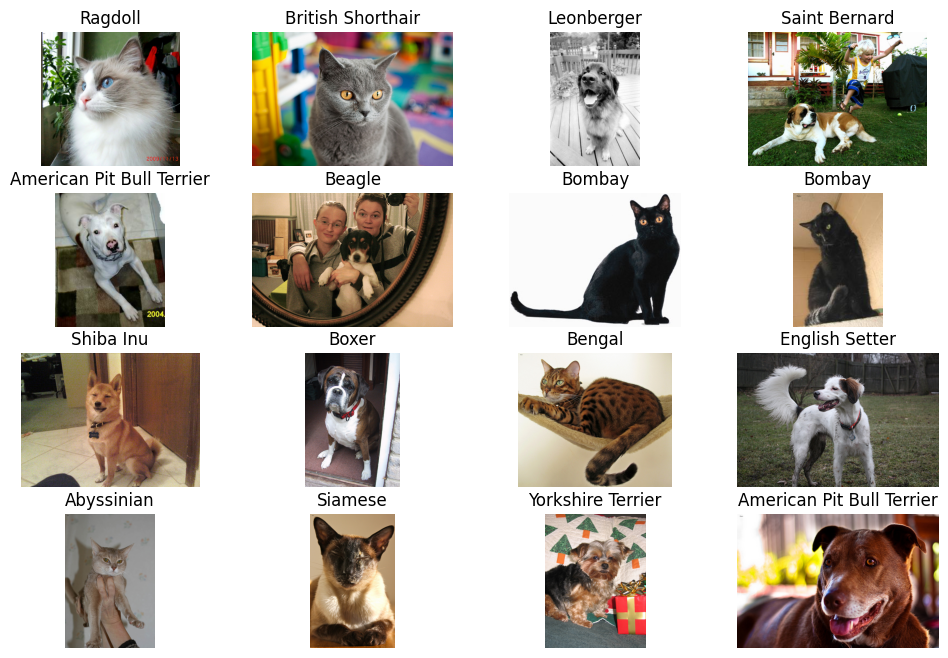

In [23]:
data = train_data
size = 4

# We load the training data without visual transformations so we can visualize the images
visual_data = OxfordIIITPet(root="../data", transform=transforms.ToTensor())

figure = plt.figure(figsize=(3*size, 2*size))
for i in range(1, size**2 + 1):
    sample_idx = torch.randint(len(visual_data), size=(1,)).item()
    image, label = visual_data[sample_idx]
    plt.subplot(size, size, i)
    plt.title(label_to_breed[label])
    plt.axis("off")
    plt.imshow(image.permute(1, 2, 0))
plt.show()

In [24]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3935575].


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

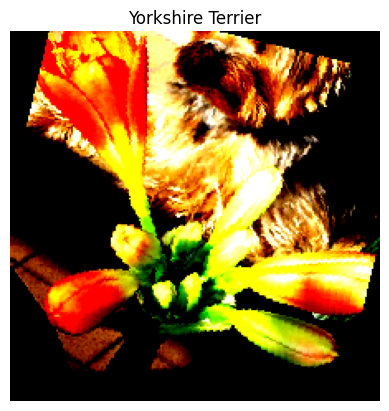

In [25]:
# Display some pre-processed image and label
train_features, train_labels = next(iter(train_dataloader))  # Get next batch of the iterable
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
image = train_features[0]
label = train_labels[0]
plt.imshow(image.permute(1, 2, 0))
plt.title(label_to_breed[label.item()])
plt.axis("off")

## Model

We will explore several models, starting with ResNets

In [26]:
from torchvision import models
from torch import nn
from torch import optim

### Loading

In [27]:
def load_model(model):
    """
    Load a pre-trained model and set it up for training:
    replace the last fully-connected layer and freeze
    the rest of the model.
    """
    # Freeze all the layers in the base model
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of input features for the classifier
    num_ftrs = model.fc.in_features
    num_classes = len(class_names)

    # Create a new fully-connected layer for our new classes
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
    ) 

    # Move model to device
    model.to(device)
    
    return model

In [28]:
# Set up ResNet-18
model_resnet18 =  models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_resnet18 = load_model(model_resnet18)
# Set up ResNet-34
model_resnet34 =  models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
model_resnet34 = load_model(model_resnet34)

### Training
We are going to implement the fine-tuning of these models in two parts:
1. We train just the last layer with a not very small learning rate (between 0.01 and 0.001) for a few epochs in order to get the new randomly initialized classifier's head to a stable and reasonable state without disturbing the pre-trained weights.

2. We unfreeze all the layers of our model and train it with a very small learning rate (between 0.0001 and 0.00001) for a few more epochs to allow the powerful, pre-trained feature extraction layers to make small, subtle adjustments to better suit the specific details of your dataset

In [ ]:
import torch
import wandb
import tqdm

In [ ]:
def fine_tune(model, dataloaders, loss_fn, optimizer, epochs=10, device='cuda'):
    """
    A more robust training loop that tracks and returns history.
    """
    # Create a dictionary to store training history
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    train_dataloader, test_dataloader = dataloaders

    # Loop through epochs
    for epoch in range(epochs):
        ### Training Phase ###
        model.train()
        
        train_loss = 0.0
        for batch, (X, y) in enumerate(train_dataloader):
            # Move data to target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # Optimizer zero grad
            optimizer.zero_grad()

            # Loss backward
            loss.backward()

            # Optimizer step
            optimizer.step()

        # Calculate average training loss for the epoch
        train_loss /= len(train_dataloader)

        ### Validation Phase ###
        model.eval() # Set model to evaluation mode
        
        val_loss, val_acc = 0.0, 0.0
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                
                # Forward pass
                val_pred = model(X)
                
                # Calculate loss and accuracy
                val_loss += loss_fn(val_pred, y).item()
                val_acc += (val_pred.argmax(dim=1) == y).sum().item()

        # Calculate metrics over the whole validation set
        val_loss /= len(test_dataloader)
        val_acc /= len(test_dataloader.dataset)

        # Print progress
        print(f"Epoch: {epoch+1} | "
              f"Train loss: {train_loss:.4f} | "
              f"Val loss: {val_loss:.4f} | "
              f"Val acc: {val_acc:.4f}")

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        wandb.log({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        
    return history
    
def fine_tune_full(model, dataloaders, loss_fn, optimizers, epochs_head=5, epochs_full=5, device='cuda'):
    """
    """
    optimizer_head, optimizer_full = optimizers
    
    # Train the head of the model
    print('Training model\'s head...')
    history_head = fine_tune(model, dataloaders, loss_fn, optimizer_head, epochs=epochs_head, device=device)
    
    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True
        
    print('Training full model...')
    # Train the full model
    history_full = fine_tune(model, dataloaders, loss_fn, optimizer_full, epochs=epochs_full, device=device)
    print('Finished Training')
    
    # Join the histories
    history = {'train_loss': history_head['train_loss'] + history_full['train_loss'], 
               'val_loss': history_head['val_loss'] + history_full['val_loss'], 
               'val_acc': history_head['val_acc'] + history_full['val_acc']}
    
    return history

In [30]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizers for training only the parameters our classifiers' heads
optim_18_head = optim.Adam(model_resnet18.fc.parameters(), lr=0.001)
optim_34_head = optim.Adam(model_resnet34.fc.parameters(), lr=0.001)

In [31]:
# Optimizers for training the full models
optim_18_full = optim.Adam(model_resnet18.parameters(), lr=0.0001, weight_decay=0.005)
optim_34_full = optim.Adam(model_resnet34.parameters(), lr=0.0001, weight_decay=0.005)

In [ ]:
# Initialize experiment tracking for ResNet-18
wandb.init(
    entity = 'nicdeluc-learning',
    project = 'pet-breed-classification',
    config = {
        'lr_head': 0.001,
        'lr_full': 0.0001,
        'architecture': 'ResNet-18',
        'dataset': 'OxfordIIITPet',
        'epochs_head': 10,
        'epochs_full': 20
    }
)

# Fine-tune ResNet-18
dataloaders_18 = train_dataloader, test_dataloader
optims_18 = optim_18_head, optim_18_full
history_resnet_18 = fine_tune_full(model_resnet18, dataloaders_18, loss_fn, optims_18, epochs_head=10, epochs_full=20)

# Finish the experiment
wandb.finish()

epoch,▁▁▂▂▂▃▃▄▄▄▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▄▃▃▃▃▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▆▇▆▇▆▇▇▇▆█▇▇████▇██████▇█▇▇▇
val_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
epoch,20
train_loss,0.34137
val_acc,0.89261
val_loss,0.39378


Training model's head...
Epoch: 1 | Train loss: 3.0928 | Val loss: 1.7324 | Val acc: 0.6806
Epoch: 2 | Train loss: 1.9651 | Val loss: 1.0515 | Val acc: 0.7999
Epoch: 3 | Train loss: 1.5164 | Val loss: 0.8343 | Val acc: 0.8185
Epoch: 4 | Train loss: 1.3734 | Val loss: 0.6989 | Val acc: 0.8422
Epoch: 5 | Train loss: 1.2419 | Val loss: 0.6271 | Val acc: 0.8534
Epoch: 6 | Train loss: 1.1793 | Val loss: 0.5678 | Val acc: 0.8583
Epoch: 7 | Train loss: 1.1134 | Val loss: 0.5437 | Val acc: 0.8605
Epoch: 8 | Train loss: 1.0623 | Val loss: 0.5203 | Val acc: 0.8596
Epoch: 9 | Train loss: 1.0822 | Val loss: 0.5069 | Val acc: 0.8651
Epoch: 10 | Train loss: 1.0602 | Val loss: 0.4874 | Val acc: 0.8621
Training full model...
Epoch: 1 | Train loss: 0.8660 | Val loss: 0.3807 | Val acc: 0.8765
Epoch: 2 | Train loss: 0.6992 | Val loss: 0.3521 | Val acc: 0.8923
Epoch: 3 | Train loss: 0.6452 | Val loss: 0.3442 | Val acc: 0.8921
Epoch: 4 | Train loss: 0.5616 | Val loss: 0.3418 | Val acc: 0.8910
Epoch: 5 | Tr

In [ ]:
# Initialize experiment tracking for ResNet-34
wandb.init(
    entity = 'nicdeluc-learning',
    project = 'pet-breed-classification',
    config = {
        'lr_head': 0.001,
        'lr_full': 0.0001,
        'architecture': 'ResNet-34',
        'dataset': 'OxfordIIITPet',
        'epochs_head': 10,
        'epochs_full': 20
    }
)

# Fine-tune ResNet-34
dataloaders_34 = train_dataloader, test_dataloader
optims_34 = optim_34_head, optim_34_full
history_resnet_34 = fine_tune_full(model_resnet34, dataloaders_34, loss_fn, optims_34, epochs_head=10, epochs_full=20)

# Finish the experiment
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▃▃▄▄▄▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▆▇▆▆▆▇▇█▇▇█████████▇▇███▇
val_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,0.3376
val_acc,0.88062
val_loss,0.3905


Training model's head...
Epoch: 1 | Train loss: 2.9991 | Val loss: 1.5922 | Val acc: 0.7454
Epoch: 2 | Train loss: 1.7983 | Val loss: 0.9173 | Val acc: 0.8523
Epoch: 3 | Train loss: 1.3900 | Val loss: 0.7068 | Val acc: 0.8588
Epoch: 4 | Train loss: 1.2469 | Val loss: 0.5822 | Val acc: 0.8749
Epoch: 5 | Train loss: 1.1296 | Val loss: 0.5123 | Val acc: 0.8651
Epoch: 6 | Train loss: 1.0446 | Val loss: 0.4856 | Val acc: 0.8722
Epoch: 7 | Train loss: 0.9945 | Val loss: 0.4613 | Val acc: 0.8648
Epoch: 8 | Train loss: 0.9640 | Val loss: 0.4277 | Val acc: 0.8795
Epoch: 9 | Train loss: 0.9461 | Val loss: 0.4384 | Val acc: 0.8733
Epoch: 10 | Train loss: 0.9419 | Val loss: 0.4101 | Val acc: 0.8757
Training full model...
Epoch: 1 | Train loss: 0.8099 | Val loss: 0.3950 | Val acc: 0.8664
Epoch: 2 | Train loss: 0.6164 | Val loss: 0.3082 | Val acc: 0.9008
Epoch: 3 | Train loss: 0.5673 | Val loss: 0.3348 | Val acc: 0.8907
Epoch: 4 | Train loss: 0.4919 | Val loss: 0.3400 | Val acc: 0.8855
Epoch: 5 | Tr

In [ ]:
# Save the models
RESNET_18_PATH = '../tuned_models/fine_tuned_resnet18.pth'
torch.save(model_resnet18.state_dict(), RESNET_18_PATH)
RESNET_34_PATH = '../tuned_models/fine_tuned_resnet34.pth'
torch.save(model_resnet34.state_dict(), RESNET_34_PATH)

In [ ]:
# Funtion to plot training and test losses and accuracy
def plot_history(history):
    # Extract data from the history dictionary
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    val_acc = history['val_acc']
    
    # Create an x-axis for epochs
    epochs = range(1, len(train_loss) + 1)
    
    # Create a figure with two subplots
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: training and validation loss
    ax1.plot(epochs, train_loss, 'b-o', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    ax1.set_title('Training & Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot 2: Validation Accuracy
    ax2.plot(epochs, val_acc, 'g-o', label='Validation Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    # Show the plots
    plt.tight_layout()
    plt.show()

## Metrics

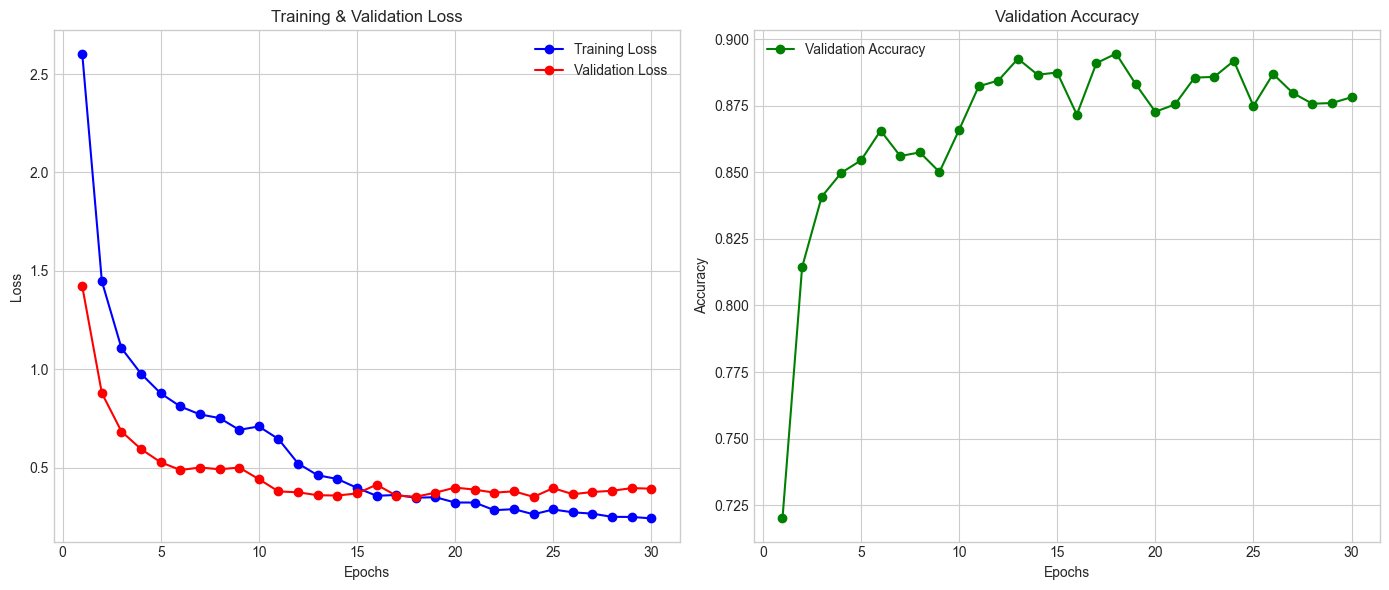

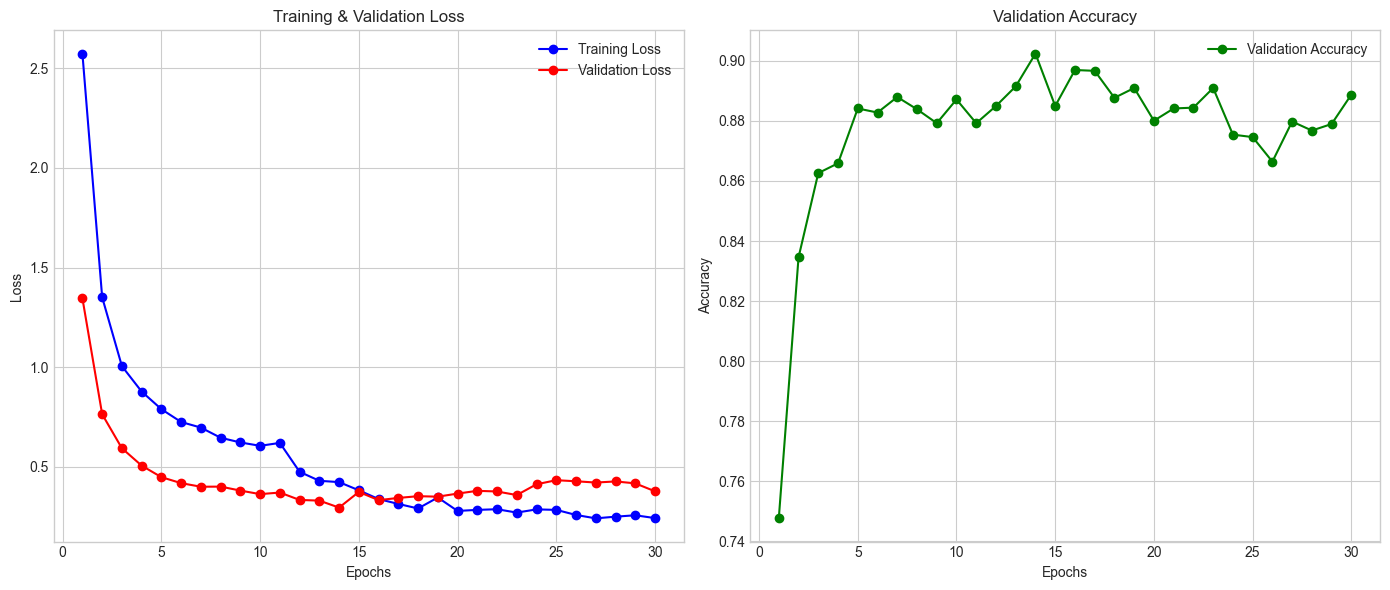

In [ ]:
# Plot the histories
plot_history(history_resnet_18)
plot_history(history_resnet_34)